In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as ps

# In this notebook we will use AutoML's TPOTClassifier tool to generate a ML pipeline to determine whether a stock will go up or down on the next day

In [83]:
# Read 3 raw datasets that we will join 
aapl = pd.read_csv('../Data/AAPL.csv')
vix = pd.read_csv('../Data/VIX.csv')
tenyr = pd.read_csv('../Data/TenYearTreasury.csv')

## Data Cleaning

In [50]:
# Turn dates to datetimes so that we can merge on them 
aapl['Date'] = pd.to_datetime(aapl.Date)
vix['Date'] = pd.to_datetime(vix.Date)
tenyr['Date'] = pd.to_datetime(tenyr.Date)

In [51]:
vix.drop(['VIX_Volume'], axis=1, inplace=True)
tenyr.drop(['TenYr_Volume'], axis=1, inplace=True)

In [52]:
vix.head()

Date   VIX_Open   VIX_High    VIX_Low  VIX_Close  VIX_AdjClose
0 1990-01-02  17.240000  17.240000  17.240000  17.240000     17.240000
1 1990-01-03  18.190001  18.190001  18.190001  18.190001     18.190001
2 1990-01-04  19.219999  19.219999  19.219999  19.219999     19.219999
3 1990-01-05  20.110001  20.110001  20.110001  20.110001     20.110001
4 1990-01-08  20.260000  20.260000  20.260000  20.260000     20.260000

In [53]:
# Merge Apple's stock data with VIX data on the date
aaplvix = aapl.merge(vix, how='inner', on=['Date'])

In [54]:
# Merge Apple and VIX data with 10 year treasury data on the date 
df = aaplvix.merge(tenyr, how='inner', on=['Date'])

In [55]:
# Remove dates before June 29, 2007 (The day the iPhone was introduced and the business changed forever)
df = df[(df['Date'] > '2007-06-29')]

In [56]:
df.head()

Date      Open      High       Low     Close  Adj Close  \
4411 2007-07-02  4.323214  4.360357  4.260714  4.330714   3.691579   
4412 2007-07-03  4.357143  4.550000  4.339286  4.541786   3.871499   
4413 2007-07-05  4.600000  4.748929  4.596071  4.741071   4.041373   
4414 2007-07-06  4.754643  4.762143  4.657143  4.725000   4.027674   
4415 2007-07-09  4.727857  4.746429  4.613571  4.654643   3.967700   

          Volume  VIX_Open  VIX_High  VIX_Low  VIX_Close  VIX_AdjClose  \
4411   994862400     16.48     16.48    15.31      15.40         15.40   
4412  1162481600     14.96     15.30    14.85      14.92         14.92   
4413  1453051600     15.37     15.95    15.17      15.48         15.48   
4414   874694800     15.36     15.59    14.67      14.72         14.72   
4415   995820000     15.34     15.69    15.03      15.16         15.16   

      TenYr_Open  TenYr_High  TenYr_Low  TenYr_Close  TenYr_AdjClose  
4411       5.031       5.039      4.998        4.998           4.998  
4412       4.987       5.050      4.985        5.050           5.050  
4413       5.094       5.144      5.085        5.144           5.144  
4414       5.153       5.201      5.151        5.195           5.195  
4415       5.168       5.172      5.147        5.159           5.159

In [57]:
df.tail()

Date        Open        High         Low       Close   Adj Close  \
8272 2022-11-02  148.949997  152.169998  145.000000  145.029999  144.789810   
8273 2022-11-03  142.059998  142.800003  138.750000  138.880005  138.650009   
8274 2022-11-04  142.089996  142.669998  134.380005  138.380005  138.380005   
8275 2022-11-07  137.110001  139.149994  135.669998  138.919998  138.919998   
8276 2022-11-08  140.410004  141.429993  137.490005  139.500000  139.500000   

         Volume   VIX_Open   VIX_High    VIX_Low  VIX_Close  VIX_AdjClose  \
8272   93604600  26.040001  26.620001  25.389999  25.860001     25.860001   
8273   97918500  25.980000  26.870001  25.100000  25.299999     25.299999   
8274  140716700  25.629999  25.709999  24.000000  24.549999     24.549999   
8275   83374600  25.670000  25.670000  24.340000  24.350000     24.350000   
8276   89908500  24.709999  26.160000  24.240000  25.540001     25.540001   

      TenYr_Open  TenYr_High  TenYr_Low  TenYr_Close  TenYr_AdjClose  
8272       4.044       4.078      3.976        4.059           4.059  
8273       4.183       4.223      4.111        4.124           4.124  
8274       4.165       4.209      4.104        4.156           4.156  
8275       4.142       4.218      4.142        4.214           4.214  
8276       4.197       4.203      4.121        4.126           4.126

In [58]:
df.describe()

Open         High          Low        Close    Adj Close  \
count  3866.000000  3866.000000  3866.000000  3866.000000  3866.000000   
mean     42.937275    43.418259    42.463527    42.958508    41.265837   
std      45.773592    46.349196    45.221846    45.806767    46.035245   
min       2.835357     2.928571     2.792857     2.792857     2.380681   
25%      12.355268    12.446786    12.284375    12.375625    10.549202   
50%      25.342500    25.564999    25.133750    25.356250    23.073355   
75%      48.266876    48.741875    47.961250    48.357501    46.645178   
max     182.630005   182.940002   179.119995   182.009995   180.959732   

             Volume     VIX_Open     VIX_High      VIX_Low    VIX_Close  \
count  3.866000e+03  3866.000000  3866.000000  3866.000000  3866.000000   
mean   3.623118e+08    20.663024    21.733430    19.613342    20.525246   
std    3.595740e+08     9.483127    10.179887     8.739904     9.427005   
min    4.100000e+07     9.010000     9.310000     8.560000     9.140000   
25%    1.114622e+08    14.190000    14.830000    13.640000    14.092500   
50%    2.192764e+08    18.059999    18.990000    17.299999    18.015000   
75%    4.807005e+08    24.059999    25.317500    22.837500    24.030001   
max    3.372970e+09    82.690002    89.529999    72.760002    82.690002   

       VIX_AdjClose   TenYr_Open   TenYr_High    TenYr_Low  TenYr_Close  \
count   3866.000000  3865.000000  3865.000000  3865.000000  3865.000000   
mean      20.525246     2.465931     2.496438     2.435241     2.465468   
std        9.427005     0.879980     0.885529     0.874094     0.878992   
min        9.140000     0.484000     0.538000     0.398000     0.499000   
25%       14.092500     1.833000     1.860000     1.811000     1.835000   
50%       18.015000     2.390000     2.418000     2.364000     2.391000   
75%       24.030001     2.984000     3.012000     2.955000     2.985000   
max       82.690002     5.168000     5.201000     5.151000     5.195000   

       TenYr_AdjClose  
count     3865.000000  
mean         2.465468  
std          0.878992  
min          0.499000  
25%          1.835000  
50%          2.391000  
75%          2.985000  
max          5.195000

## Feature Engineering

In [59]:
# Add a feature for the NextDayChange (will be the y value to predict)
df['NextDayChange'] = ((df['Close'].shift(-1) / df['Close'] - 1) * 100).fillna(0)

In [60]:
df.tail()

Date        Open        High         Low       Close   Adj Close  \
8272 2022-11-02  148.949997  152.169998  145.000000  145.029999  144.789810   
8273 2022-11-03  142.059998  142.800003  138.750000  138.880005  138.650009   
8274 2022-11-04  142.089996  142.669998  134.380005  138.380005  138.380005   
8275 2022-11-07  137.110001  139.149994  135.669998  138.919998  138.919998   
8276 2022-11-08  140.410004  141.429993  137.490005  139.500000  139.500000   

         Volume   VIX_Open   VIX_High    VIX_Low  VIX_Close  VIX_AdjClose  \
8272   93604600  26.040001  26.620001  25.389999  25.860001     25.860001   
8273   97918500  25.980000  26.870001  25.100000  25.299999     25.299999   
8274  140716700  25.629999  25.709999  24.000000  24.549999     24.549999   
8275   83374600  25.670000  25.670000  24.340000  24.350000     24.350000   
8276   89908500  24.709999  26.160000  24.240000  25.540001     25.540001   

      TenYr_Open  TenYr_High  TenYr_Low  TenYr_Close  TenYr_AdjClose  \
8272       4.044       4.078      3.976        4.059           4.059   
8273       4.183       4.223      4.111        4.124           4.124   
8274       4.165       4.209      4.104        4.156           4.156   
8275       4.142       4.218      4.142        4.214           4.214   
8276       4.197       4.203      4.121        4.126           4.126   

      NextDayChange  
8272      -4.240498  
8273      -0.360023  
8274       0.390225  
8275       0.417508  
8276       0.000000

### Let's look at our data

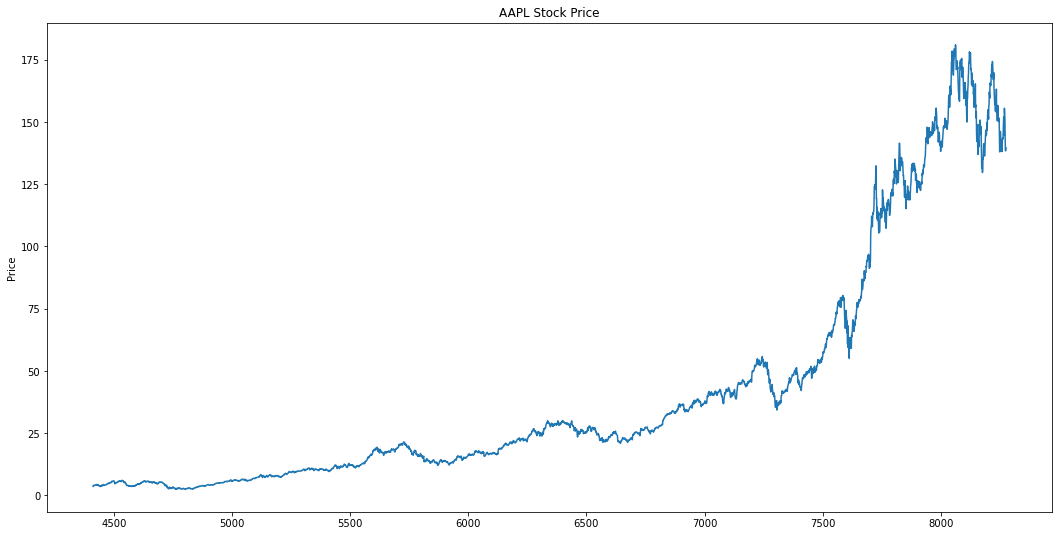

In [61]:
plt.figure(figsize=(18,9))
plt.plot(df['Adj Close'])
plt.ylabel("Price")
plt.title("AAPL Stock Price")
plt.show()

## More data cleaning

In [62]:
# Get the means of columns with any missing values 
# Could make this a mean within 10 values surrounding possibly
def get_missing_values(df):
    values = {}
    for feat in df.columns:
        if df[feat].isna().any():
            values[feat] = round(df[feat].mean(),3)
    return values

In [63]:
values = get_missing_values(df)

In [64]:
values

{'TenYr_Open': 2.466,
 'TenYr_High': 2.496,
 'TenYr_Low': 2.435,
 'TenYr_Close': 2.465,
 'TenYr_AdjClose': 2.465}

## Data visualization

<AxesSubplot:>

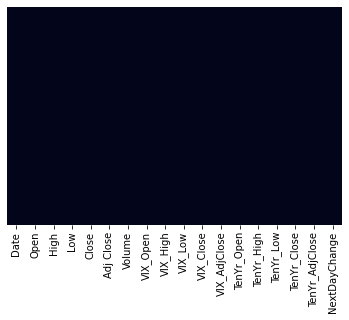

In [65]:
# Fill empty values and display heatmap
df.fillna(value=values, inplace=True)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False)

In [66]:
# Summary of columns with null values 
Sum = df.isnull().sum()
Percentage = ( df.isnull().sum()/df.isnull().count())

pd.concat([Sum,Percentage], axis =1, keys= ['Sum', 'Percentage'])

Sum  Percentage
Date              0         0.0
Open              0         0.0
High              0         0.0
Low               0         0.0
Close             0         0.0
Adj Close         0         0.0
Volume            0         0.0
VIX_Open          0         0.0
VIX_High          0         0.0
VIX_Low           0         0.0
VIX_Close         0         0.0
VIX_AdjClose      0         0.0
TenYr_Open        0         0.0
TenYr_High        0         0.0
TenYr_Low         0         0.0
TenYr_Close       0         0.0
TenYr_AdjClose    0         0.0
NextDayChange     0         0.0

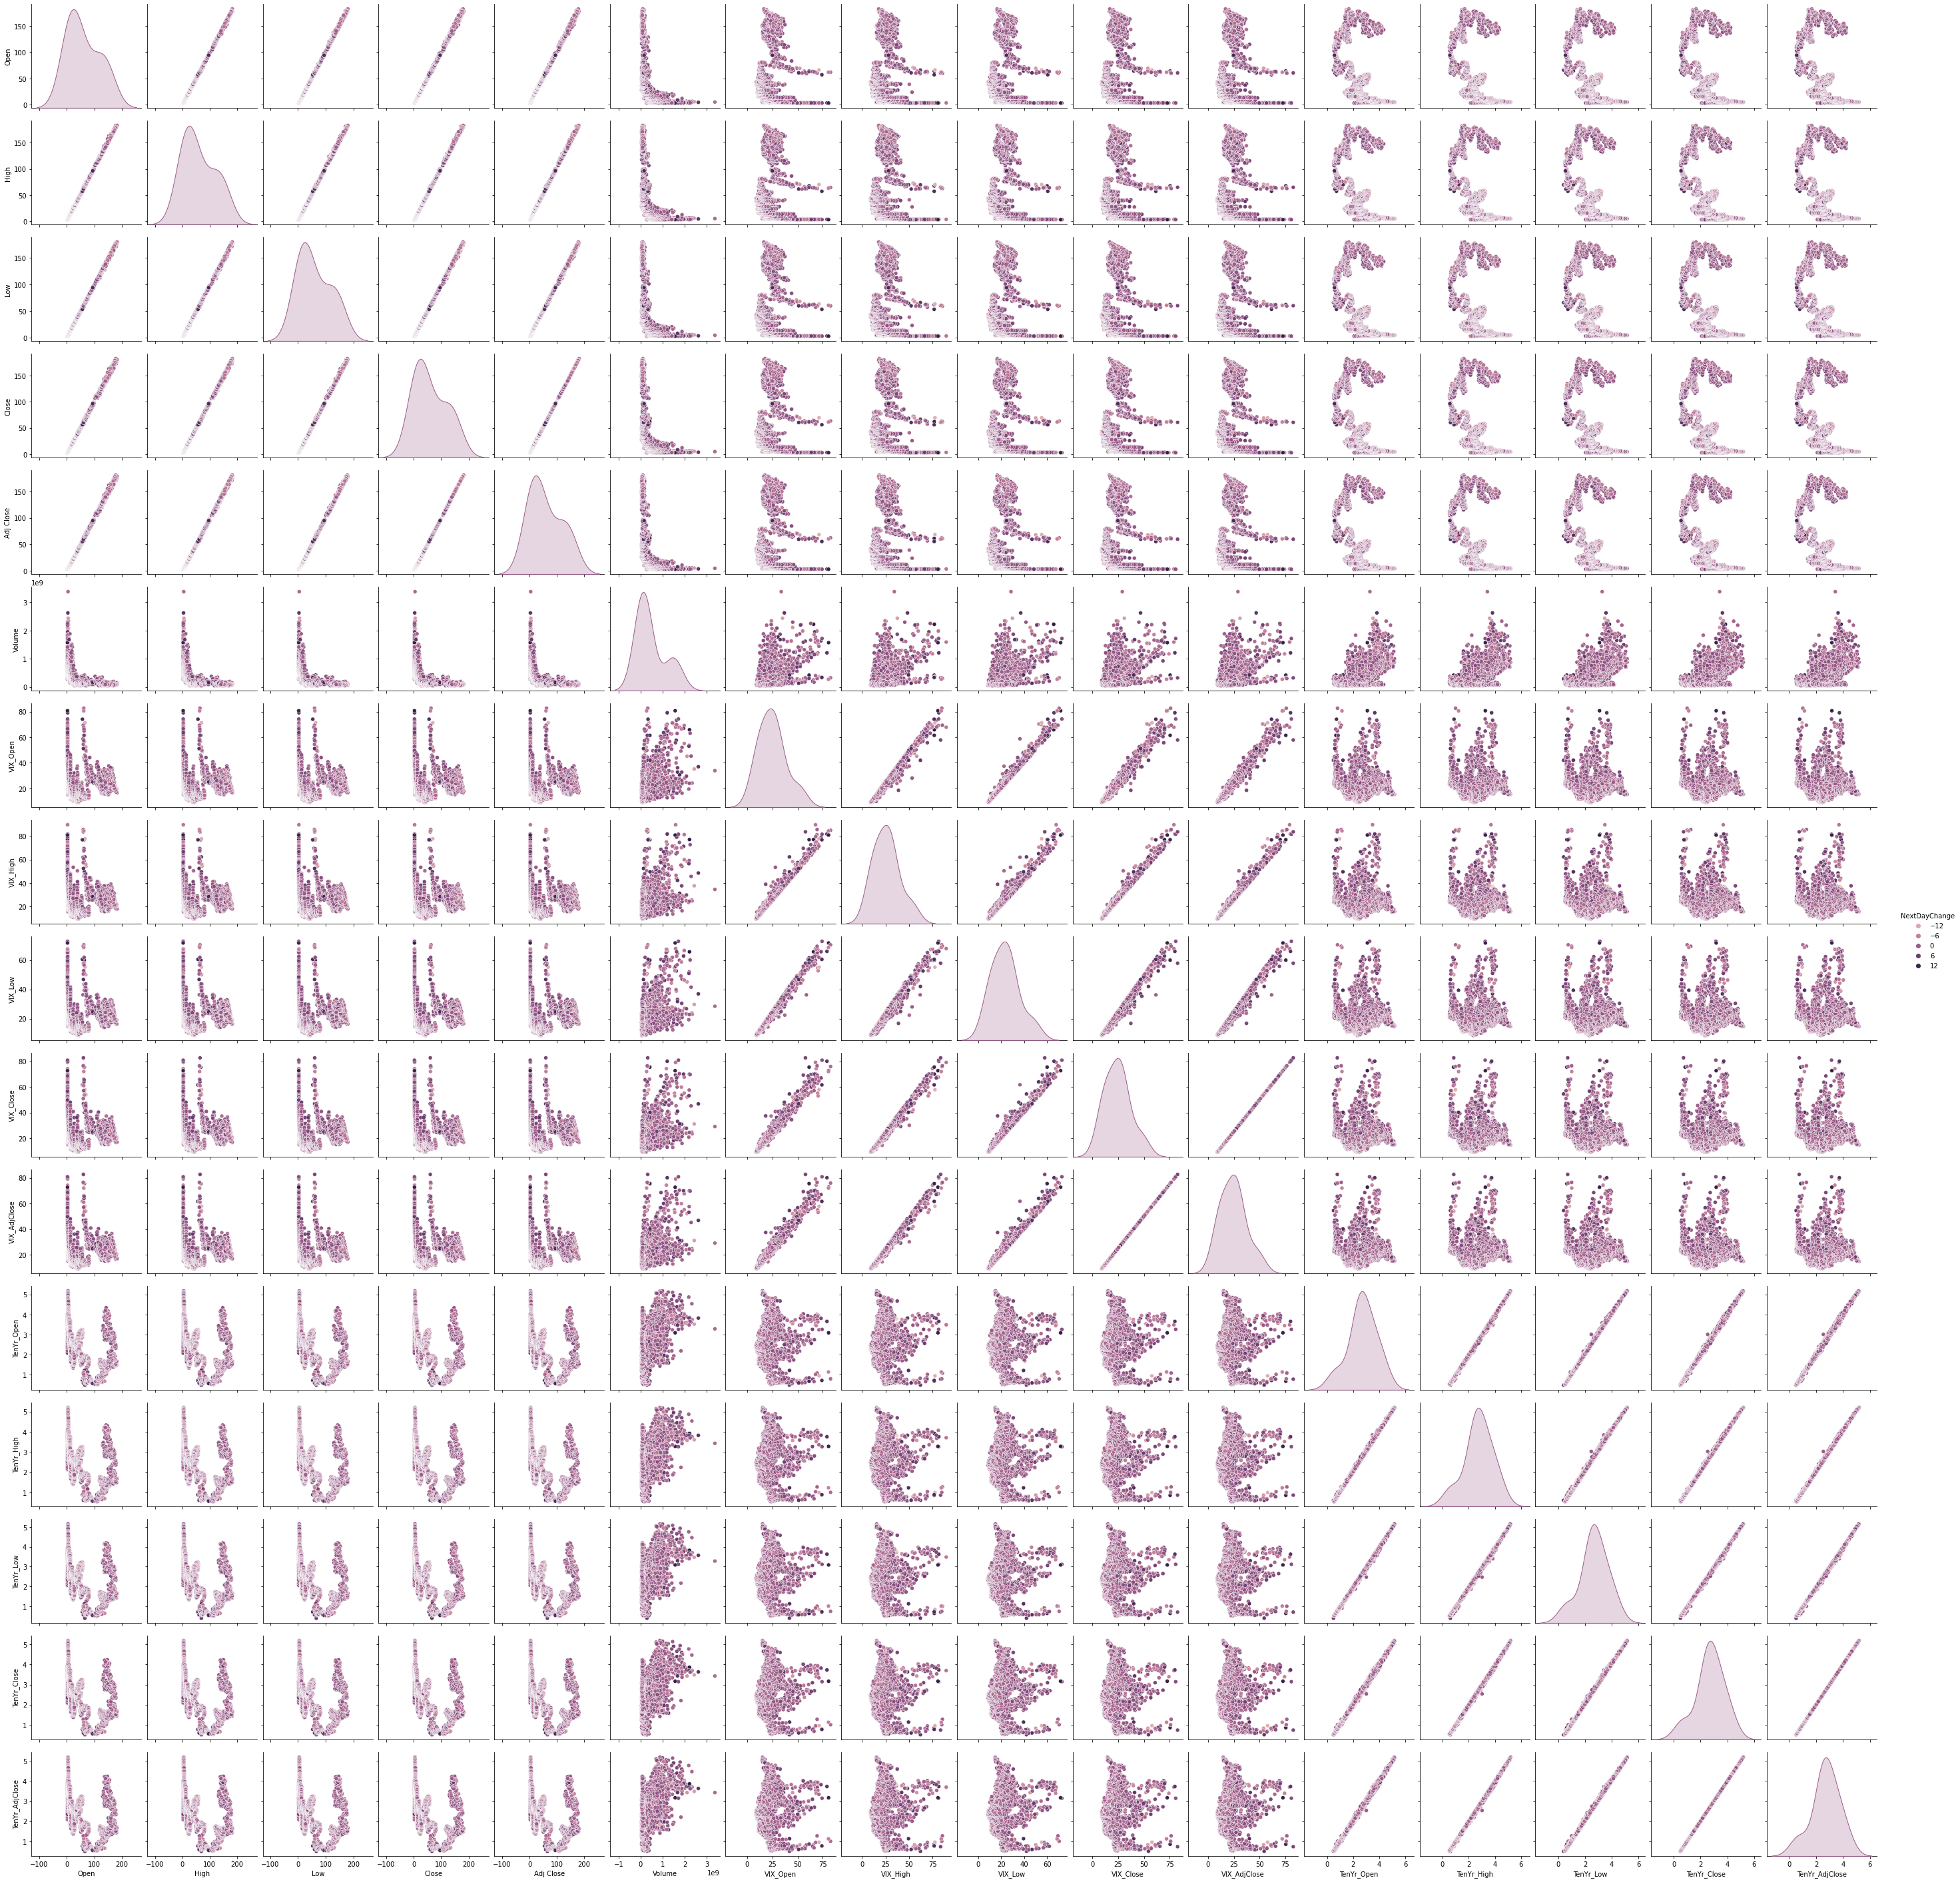

In [67]:
sns.pairplot(df, hue="NextDayChange")

Text(0, 0.5, 'correlation')

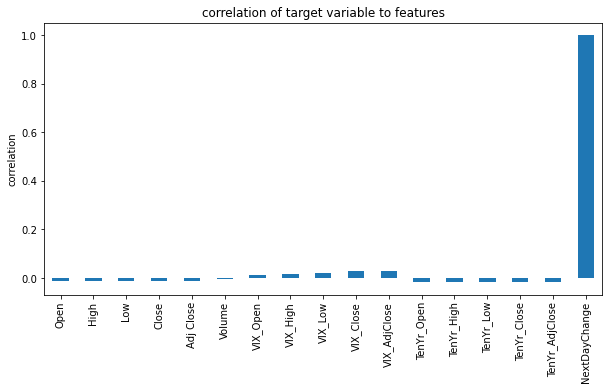

In [68]:
# Plot correlation of the next day's change to current features
plt.figure(figsize=(10,5))
ax = df.corr()['NextDayChange'].plot(kind='bar',title='correlation of target variable to features')
ax.set_ylabel('correlation')

<AxesSubplot:>

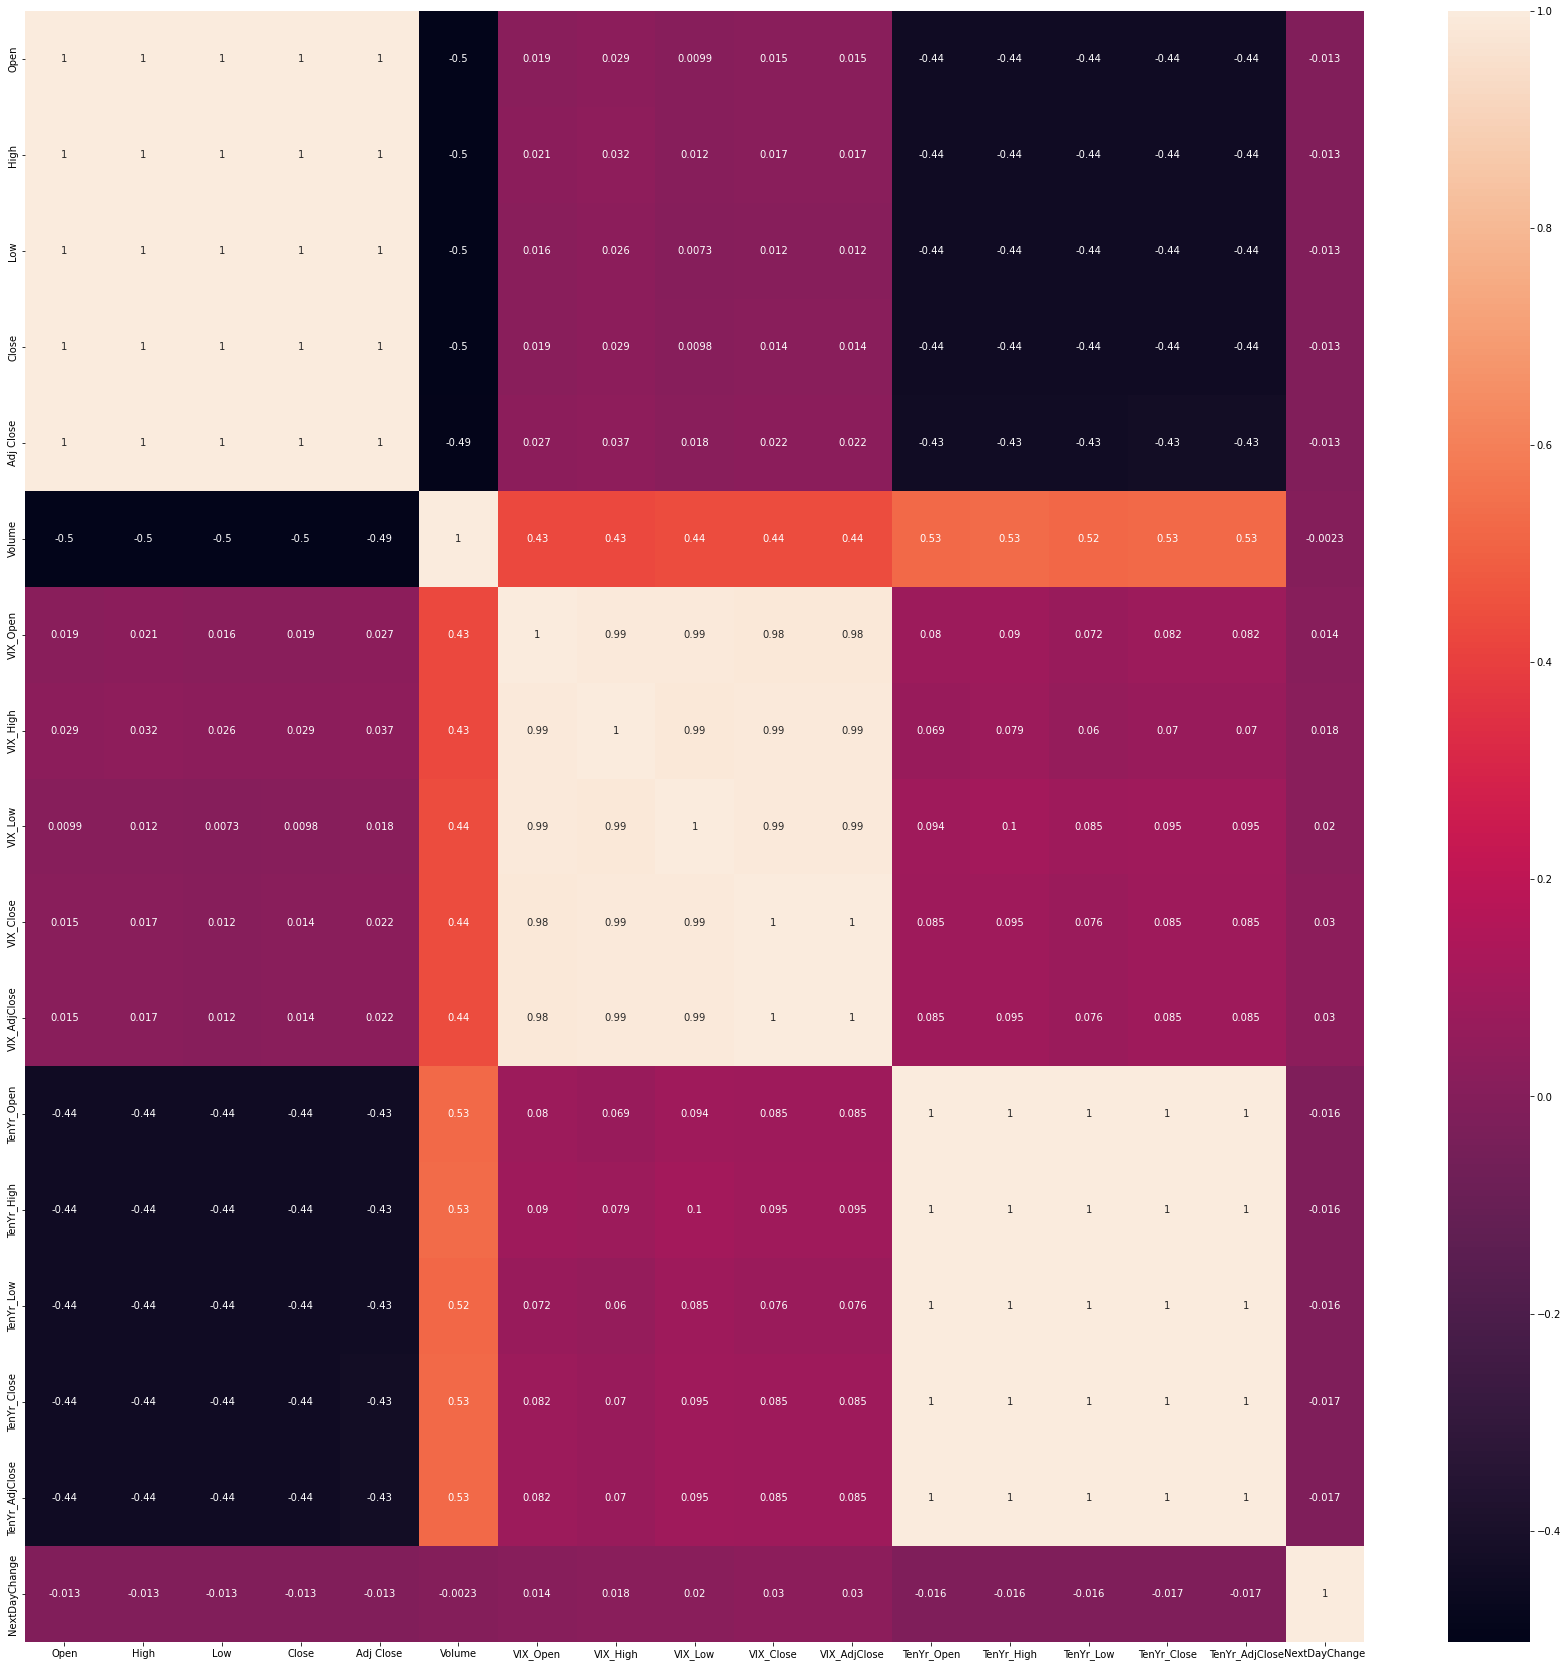

In [69]:
plt.figure(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True)

In [70]:
# Classify percentage changes to integers
bins = [-100, 0, 100]
labels = ['Down', 'Up']
df_bins2 = df.copy()
df_bins2['Direction'] = pd.cut(x=df_bins2['NextDayChange'], bins=bins, labels=labels)
print(df_bins2[['Direction', 'NextDayChange']].tail())

     Direction  NextDayChange
8272      Down      -4.240498
8273      Down      -0.360023
8274        Up       0.390225
8275        Up       0.417508
8276      Down       0.000000


Text(0.5, 1.0, 'Direction Classifier')

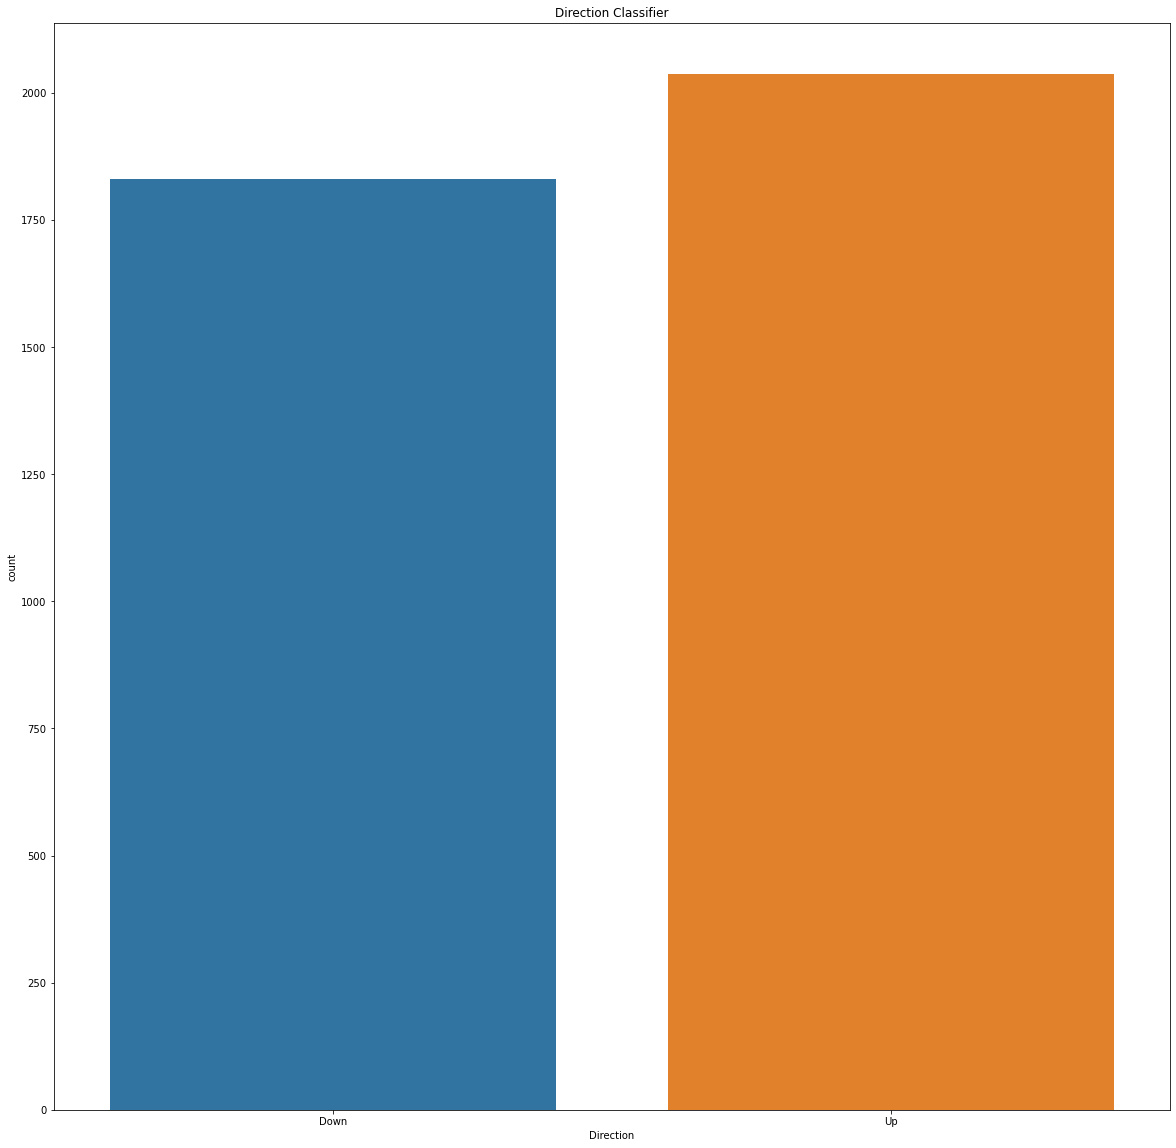

In [71]:
# Plot the number of "up days" compared to the number of "down days"
plt.figure(figsize=(20,20))
sns.countplot(data=df_bins2, x='Direction').set_title("Direction Classifier")

In [72]:
df_bins2.head()

Date      Open      High       Low     Close  Adj Close  \
4411 2007-07-02  4.323214  4.360357  4.260714  4.330714   3.691579   
4412 2007-07-03  4.357143  4.550000  4.339286  4.541786   3.871499   
4413 2007-07-05  4.600000  4.748929  4.596071  4.741071   4.041373   
4414 2007-07-06  4.754643  4.762143  4.657143  4.725000   4.027674   
4415 2007-07-09  4.727857  4.746429  4.613571  4.654643   3.967700   

          Volume  VIX_Open  VIX_High  VIX_Low  VIX_Close  VIX_AdjClose  \
4411   994862400     16.48     16.48    15.31      15.40         15.40   
4412  1162481600     14.96     15.30    14.85      14.92         14.92   
4413  1453051600     15.37     15.95    15.17      15.48         15.48   
4414   874694800     15.36     15.59    14.67      14.72         14.72   
4415   995820000     15.34     15.69    15.03      15.16         15.16   

      TenYr_Open  TenYr_High  TenYr_Low  TenYr_Close  TenYr_AdjClose  \
4411       5.031       5.039      4.998        4.998           4.998   
4412       4.987       5.050      4.985        5.050           5.050   
4413       5.094       5.144      5.085        5.144           5.144   
4414       5.153       5.201      5.151        5.195           5.195   
4415       5.168       5.172      5.147        5.159           5.159   

      NextDayChange Direction  
4411       4.873838        Up  
4412       4.387811        Up  
4413      -0.338974      Down  
4414      -1.489037      Down  
4415       1.549915        Up

In [73]:
df_bins2.tail()

Date        Open        High         Low       Close   Adj Close  \
8272 2022-11-02  148.949997  152.169998  145.000000  145.029999  144.789810   
8273 2022-11-03  142.059998  142.800003  138.750000  138.880005  138.650009   
8274 2022-11-04  142.089996  142.669998  134.380005  138.380005  138.380005   
8275 2022-11-07  137.110001  139.149994  135.669998  138.919998  138.919998   
8276 2022-11-08  140.410004  141.429993  137.490005  139.500000  139.500000   

         Volume   VIX_Open   VIX_High    VIX_Low  VIX_Close  VIX_AdjClose  \
8272   93604600  26.040001  26.620001  25.389999  25.860001     25.860001   
8273   97918500  25.980000  26.870001  25.100000  25.299999     25.299999   
8274  140716700  25.629999  25.709999  24.000000  24.549999     24.549999   
8275   83374600  25.670000  25.670000  24.340000  24.350000     24.350000   
8276   89908500  24.709999  26.160000  24.240000  25.540001     25.540001   

      TenYr_Open  TenYr_High  TenYr_Low  TenYr_Close  TenYr_AdjClose  \
8272       4.044       4.078      3.976        4.059           4.059   
8273       4.183       4.223      4.111        4.124           4.124   
8274       4.165       4.209      4.104        4.156           4.156   
8275       4.142       4.218      4.142        4.214           4.214   
8276       4.197       4.203      4.121        4.126           4.126   

      NextDayChange Direction  
8272      -4.240498      Down  
8273      -0.360023      Down  
8274       0.390225        Up  
8275       0.417508        Up  
8276       0.000000      Down

In [74]:
# Drop percentage change since it will always correlate
df_bins2 = df_bins2.drop('NextDayChange', axis=1).copy()

In [75]:
# Create X and y data by using Direction for y and the rest for X
X = df_bins2.drop(columns=['Date', 'Direction'], axis=1)
y = df_bins2.Direction

In [76]:
import tpot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [77]:
# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [78]:
X_train

Open        High         Low       Close   Adj Close     Volume  \
7369   48.697498   49.092499   48.285000   48.922501   47.421322   76457200   
6238   24.817499   25.055000   24.510000   24.975000   22.384054  191031200   
7367   47.772499   48.615002   47.762501   48.505001   47.016636   91062800   
7535   66.650002   67.000000   66.474998   66.812500   65.454712   46617600   
5448   13.232857   13.408929   13.025714   13.346429   11.376735  741969200   
...          ...         ...         ...         ...         ...        ...   
7383   51.707500   51.939999   51.279999   51.320000   49.745258   74172800   
7706  109.377502  110.392502  108.897499  110.062500  108.374229  121776800   
4682    5.550357    5.694643    5.487500    5.610000    4.782064  684070800   
6933   36.182499   36.462502   36.095001   36.382500   34.337345   79127200   
7838  134.350006  135.529999  133.690002  135.369995  133.964127   60145100   

       VIX_Open   VIX_High    VIX_Low  VIX_Close  VIX_AdjClose  TenYr_Open  \
7369  13.840000  14.030000  13.400000  13.580000     13.580000       2.508   
6238  16.700001  17.980000  15.900000  16.160000     16.160000       2.409   
7367  13.620000  13.680000  13.130000  13.360000     13.360000       2.474   
7535  12.500000  12.830000  12.120000  12.620000     12.620000       1.772   
5448  41.939999  42.880001  37.500000  39.000000     39.000000       2.135   
...         ...        ...        ...        ...           ...         ...   
7383  13.290000  14.300000  12.810000  13.250000     13.250000       2.524   
7706  23.440001  23.610001  22.860001  22.990000     22.990000       0.530   
4682  24.200001  24.219999  21.959999  22.030001     22.030001       4.062   
6933  10.790000  12.140000  10.680000  10.890000     10.890000       2.387   
7838  21.600000  22.450001  19.950001  19.969999     19.969999       1.183   

      TenYr_High  TenYr_Low  TenYr_Close  TenYr_AdjClose  
7369       2.522      2.503        2.512           2.512  
6238       2.439      2.386        2.438           2.438  
7367       2.492      2.469        2.481           2.481  
7535       1.796      1.764        1.776           1.776  
5448       2.360      2.130        2.336           2.336  
...          ...        ...          ...             ...  
7383       2.542      2.516        2.534           2.534  
7706       0.553      0.528        0.543           0.543  
4682       4.089      4.038        4.044           4.044  
6933       2.391      2.355        2.362           2.362  
7838       1.202      1.178        1.200           1.200  

[3092 rows x 16 columns]

In [84]:
y_train

7369      Up
6238    Down
7367      Up
7535    Down
5448      Up
        ... 
7383    Down
7706      Up
4682      Up
6933      Up
7838    Down
Name: Direction, Length: 3092, dtype: category
Categories (2, object): ['Down' < 'Up']

## Time to build and train the pipeline / model 

In [79]:
# TPOTClassifier handles this for us 
AutoML = tpot.TPOTClassifier(
                            generations=10,
                            population_size=100,
                            offspring_size=None,
                            mutation_rate=0.9,
                            crossover_rate=0.1,
                            scoring='accuracy',
                            cv=5,
                            subsample=1.0,
                            n_jobs=1,
                            max_time_mins=None,
                            max_eval_time_mins=5,
                            random_state=None,
                            config_dict=None,
                            template=None,
                            warm_start=True,
                            memory=None,
                            use_dask=False,
                            periodic_checkpoint_folder=None,
                            early_stop=None,
                            verbosity=2,
                            disable_update_check=False,
                            )

In [ ]:
# Let TPOTClassifier fit the best pipeline for our data
AutoML.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/1100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.54851179739741

Generation 2 - Current best internal CV score: 0.5504524993334066

Generation 3 - Current best internal CV score: 0.5504524993334066

Generation 4 - Current best internal CV score: 0.5504524993334066

Generation 5 - Current best internal CV score: 0.5504524993334066

Generation 6 - Current best internal CV score: 0.5504524993334066

Generation 7 - Current best internal CV score: 0.5504524993334066

Generation 8 - Current best internal CV score: 0.5504524993334066

Generation 9 - Current best internal CV score: 0.5504524993334066


## Now we must visualize and evaluate results

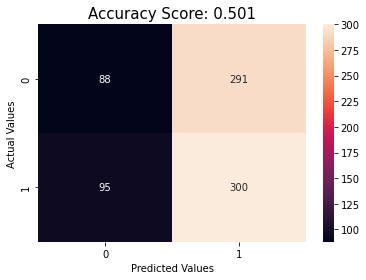

In [82]:
# let's use a confusion matrix to easily evaluate results 
from sklearn.metrics import confusion_matrix as cm
predictions = AutoML.predict(X_test)
score = round(accuracy_score(y_test, predictions), 3)
cm1 = cm(y_test, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.set_xlabel
plt.ylabel('Actual Values')
plt.labels(['Down', 'Up'])
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

In [ ]:
AutoML.export('../models/AutoMLmodel.py')